Import Required Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from pingouin import multivariate_normality
from sklearn.covariance import MinCovDet
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
import scikit_posthocs as sp

Import DataSet

In [4]:
health_fitness=pd.read_csv("C:\\UOC pdf\\3rd Year\\MachineLearning-01\\final_project\\health_fitness_dataset.csv")

In [5]:
health_fitness.head()

participant_id        date  age gender  height_cm  weight_kg  \
0               1  2024-01-01   56      F      165.3       53.7   
1               1  2024-01-04   56      F      165.3       53.9   
2               1  2024-01-05   56      F      165.3       54.2   
3               1  2024-01-07   56      F      165.3       54.4   
4               1  2024-01-09   56      F      165.3       54.7   

     activity_type  duration_minutes intensity  calories_burned  ...  \
0          Dancing                41       Low              3.3  ...   
1         Swimming                28       Low              2.9  ...   
2         Swimming                21    Medium              2.6  ...   
3  Weight Training                99    Medium             10.7  ...   
4         Swimming               100    Medium             12.7  ...   

   stress_level  daily_steps  hydration_level   bmi  resting_heart_rate  \
0             3         7128              1.5  19.6                69.5   
1             7         7925              1.8  19.6                69.5   
2             7         7557              2.7  19.6                69.5   
3             8        11120              2.6  19.6                69.5   
4             1         5406              1.5  19.6                69.5   

   blood_pressure_systolic  blood_pressure_diastolic  health_condition  \
0                    110.7                      72.9               NaN   
1                    110.7                      72.9               NaN   
2                    110.7                      72.9               NaN   
3                    110.7                      72.9               NaN   
4                    110.7                      72.9               NaN   

   smoking_status fitness_level  
0           Never          0.04  
1           Never          0.07  
2           Never          0.09  
3           Never          0.21  
4           Never          0.33  

[5 rows x 22 columns]

Check the missing values exist or not 

In [7]:
pd.isnull(health_fitness).sum()

participant_id                   0
date                             0
age                              0
gender                           0
height_cm                        0
weight_kg                        0
activity_type                    0
duration_minutes                 0
intensity                        0
calories_burned                  0
avg_heart_rate                   0
hours_sleep                      0
stress_level                     0
daily_steps                      0
hydration_level                  0
bmi                              0
resting_heart_rate               0
blood_pressure_systolic          0
blood_pressure_diastolic         0
health_condition            490275
smoking_status                   0
fitness_level                    0
dtype: int64

Remove the health_condition variable from the dataset because it contains approximately 500,000 missing values 

Check  the duplicated records

In [10]:
health_fitness.duplicated().sum()

0

In [11]:
health_fitness.columns

Index(['participant_id', 'date', 'age', 'gender', 'height_cm', 'weight_kg',
       'activity_type', 'duration_minutes', 'intensity', 'calories_burned',
       'avg_heart_rate', 'hours_sleep', 'stress_level', 'daily_steps',
       'hydration_level', 'bmi', 'resting_heart_rate',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'health_condition', 'smoking_status', 'fitness_level'],
      dtype='object')

Create additional variables like Mean Arterial Pressure and BMI 

In [13]:
health_fitness['MAP']=round((health_fitness['blood_pressure_systolic']+2*health_fitness['blood_pressure_diastolic'])/3,2)
health_fitness['BMI']=round((health_fitness['weight_kg']/(health_fitness['height_cm']/100)**2),2)

Drop Uneccesary variables

In [15]:
health_fitness=health_fitness.drop(columns=['participant_id','date','height_cm','weight_kg','bmi','blood_pressure_systolic','blood_pressure_diastolic'])

In [16]:
health_fitness.columns

Index(['age', 'gender', 'activity_type', 'duration_minutes', 'intensity',
       'calories_burned', 'avg_heart_rate', 'hours_sleep', 'stress_level',
       'daily_steps', 'hydration_level', 'resting_heart_rate',
       'health_condition', 'smoking_status', 'fitness_level', 'MAP', 'BMI'],
      dtype='object')

In [17]:
health_fitness.sample(5)

age gender    activity_type  duration_minutes intensity  \
382382   19      F       Basketball                59      High   
557170   23      M          Walking               115       Low   
117134   50      M          Running                97      High   
210885   61      F  Weight Training                28    Medium   
426347   59      M           Tennis                55    Medium   

        calories_burned  avg_heart_rate  hours_sleep  stress_level  \
382382             18.4             158          9.0             6   
557170             10.5             127          8.1             2   
117134             29.1             161          6.5             9   
210885              4.3             127          8.1            10   
426347             14.4             120          6.8             6   

        daily_steps  hydration_level  resting_heart_rate health_condition  \
382382         6694              2.0                70.7              NaN   
557170         9669              2.4                74.4              NaN   
117134         9231              1.9                75.8     Hypertension   
210885         9792              2.2                63.6              NaN   
426347         6722              2.1                70.2           Asthma   

       smoking_status  fitness_level    MAP    BMI  
382382        Current          16.36  89.60  35.91  
557170          Never           8.96  91.53  29.51  
117134          Never           4.23  86.93  28.70  
210885          Never           5.01  85.37  26.86  
426347          Never          14.60  95.93  38.28

Summary Table of numerical features

In [19]:
health_fitness.describe()

age  duration_minutes  calories_burned  avg_heart_rate  \
count  687701.000000     687701.000000    687701.000000   687701.000000   
mean       41.658602         70.011671        15.381302      131.454165   
std        13.581770         29.147251         9.985552       17.814744   
min        18.000000         20.000000         0.800000       82.000000   
25%        30.000000         45.000000         7.800000      118.000000   
50%        42.000000         70.000000        13.000000      130.000000   
75%        53.000000         95.000000        20.700000      144.000000   
max        64.000000        120.000000        92.000000      206.000000   

         hours_sleep   stress_level    daily_steps  hydration_level  \
count  687701.000000  687701.000000  687701.000000    687701.000000   
mean        7.048799       5.252389    8628.370918         2.499427   
std         0.972068       2.770029    2054.756608         0.579050   
min         4.000000       1.000000    -419.000000         1.500000   
25%         6.400000       3.000000    7203.000000         2.000000   
50%         7.000000       5.000000    8607.000000         2.500000   
75%         7.700000       8.000000   10027.000000         3.000000   
max        10.000000      10.000000   17241.000000         3.500000   

       resting_heart_rate  fitness_level            MAP            BMI  
count       687701.000000  687701.000000  687701.000000  687701.000000  
mean            70.010547       9.524900      93.459185      33.289635  
std              5.074563       5.502485       6.427075       6.979451  
min             51.100000       0.020000      70.470000      14.250000  
25%             66.500000       4.770000      89.100000      27.920000  
50%             70.000000       9.510000      93.600000      33.280000  
75%             73.500000      14.230000      97.700000      38.600000  
max             87.100000      21.930000     117.370000      55.890000

Make the daily_step count equal zero which has a below step count zero

In [21]:
health_fitness.loc[health_fitness['daily_steps']<0,'daily_steps']=0

Get the sample from the dataset around 25,000 using Stratified sampling techniqes

In [23]:
# Define stratification columns
stratify_cols = ['intensity', 'smoking_status']

# Drop any rows with missing values in stratification columns (just in case)
df_strat = health_fitness.dropna(subset=stratify_cols)

# Perform stratified sampling
health_fitness_strat, _ = train_test_split(
    df_strat,
    train_size=25000,
    stratify=df_strat[stratify_cols],
    random_state=42
)

print("Stratified sample of 25,000 records created successfully.")

Stratified sample of 25,000 records created successfully.


In [24]:
health_fitness_strat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 565249 to 60985
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 25000 non-null  int64  
 1   gender              25000 non-null  object 
 2   activity_type       25000 non-null  object 
 3   duration_minutes    25000 non-null  int64  
 4   intensity           25000 non-null  object 
 5   calories_burned     25000 non-null  float64
 6   avg_heart_rate      25000 non-null  int64  
 7   hours_sleep         25000 non-null  float64
 8   stress_level        25000 non-null  int64  
 9   daily_steps         25000 non-null  int64  
 10  hydration_level     25000 non-null  float64
 11  resting_heart_rate  25000 non-null  float64
 12  health_condition    7223 non-null   object 
 13  smoking_status      25000 non-null  object 
 14  fitness_level       25000 non-null  float64
 15  MAP                 25000 non-null  float64
 16  BMI 

Divide the dataset into training and testing which has 70% of the data for training set and 30% of data for testing set

In [26]:
X=health_fitness_strat.drop(columns=['fitness_level'])
Y=health_fitness_strat['fitness_level']

In [27]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.7,random_state=42)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [28]:
print("Shape of the training and testing data:",X_train.shape,X_test.shape)

Shape of the training and testing data: (17500, 16) (7500, 16)


In [29]:
train_data = pd.concat([X_train, Y_train], axis=1)

analyze health condition variable

In [31]:
# Compare mean fitness_level between records with/without health_condition
print(train_data.groupby(train_data['health_condition'].isna())['fitness_level'].mean())

health_condition
False    9.383457
True     9.540862
Name: fitness_level, dtype: float64


*The difference in means (0.01) is statistically negligible. *Suggests missingness is likely MCAR (Missing Completely at Random)—no systematic bias.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14420\2482984101.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train_data, x='health_condition', y='fitness_level', ci=None)


([0, 1, 2],
 [Text(0, 0, 'Diabetes'), Text(1, 0, 'Asthma'), Text(2, 0, 'Hypertension')])

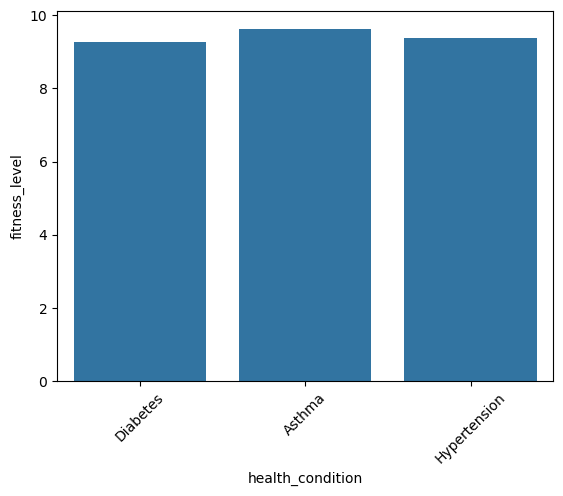

In [33]:
sns.barplot(data=train_data, x='health_condition', y='fitness_level', ci=None)
plt.xticks(rotation=45)

*Since fitness levels are similar for Hypertension, Asthma, and Diabetes in the non-missing data, it's likely that health_condition is not a strong differentiator of fitness_level, at least in this dataset.

In [35]:
X_train=X_train.drop(columns=['health_condition'])
X_test=X_test.drop(columns=['health_condition'])
Y_train=Y_train.drop(columns=['health_condition'])
Y_test=Y_test.drop(columns=['health_condition'])

Cheking univariate outliers using IQR method

In [37]:
def outliers(var):
    Q1=np.quantile(var,0.25)
    Q3=np.quantile(var,0.75)
    IQR=Q3-Q1

    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR

    count=sum(var<lower_bound)+sum(upper_bound<var)
    return count

In [38]:
numerical_features=X_train.select_dtypes(include=['number'])
for v in numerical_features.columns:
    count=outliers(X_train[v])
    print(v,"--->",count)

print("fitness_level--->",outliers(Y_train))

age ---> 0
duration_minutes ---> 0
calories_burned ---> 443
avg_heart_rate ---> 81
hours_sleep ---> 161
stress_level ---> 0
daily_steps ---> 73
hydration_level ---> 0
resting_heart_rate ---> 101
MAP ---> 123
BMI ---> 3
fitness_level---> 0


Exploratory Data Analysis

Univariate Analysis

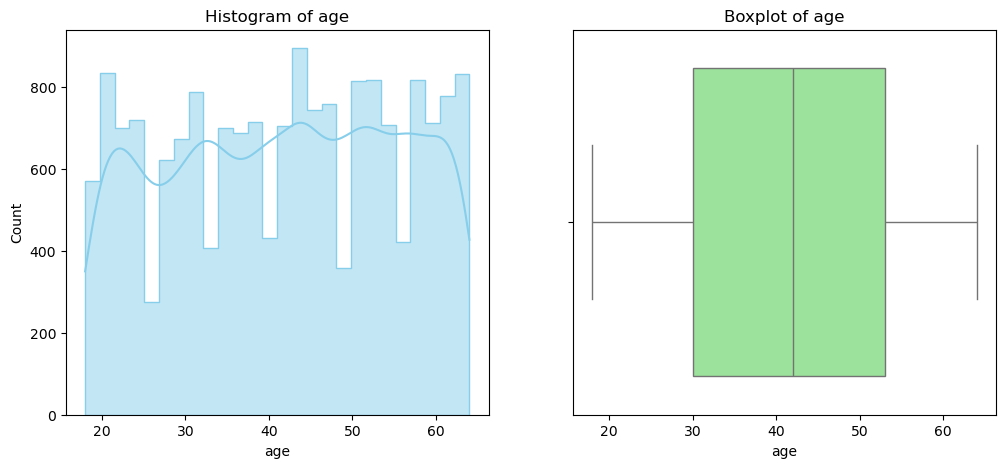

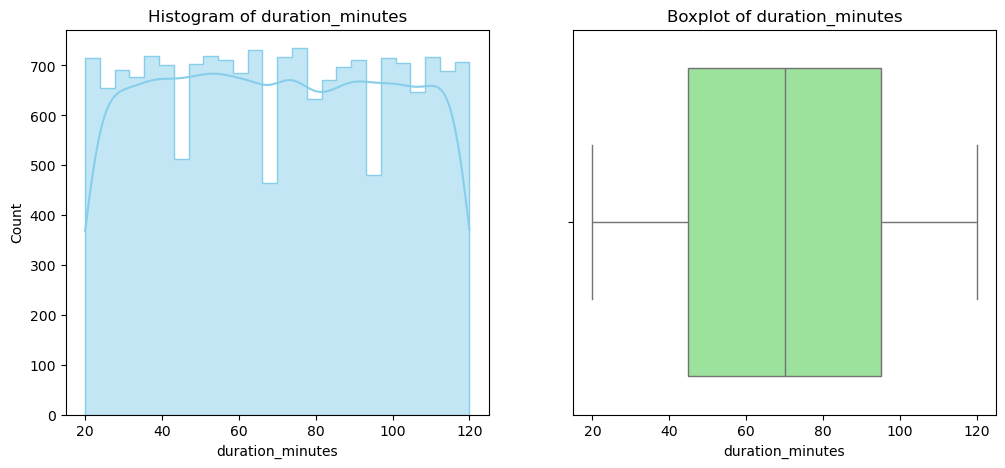

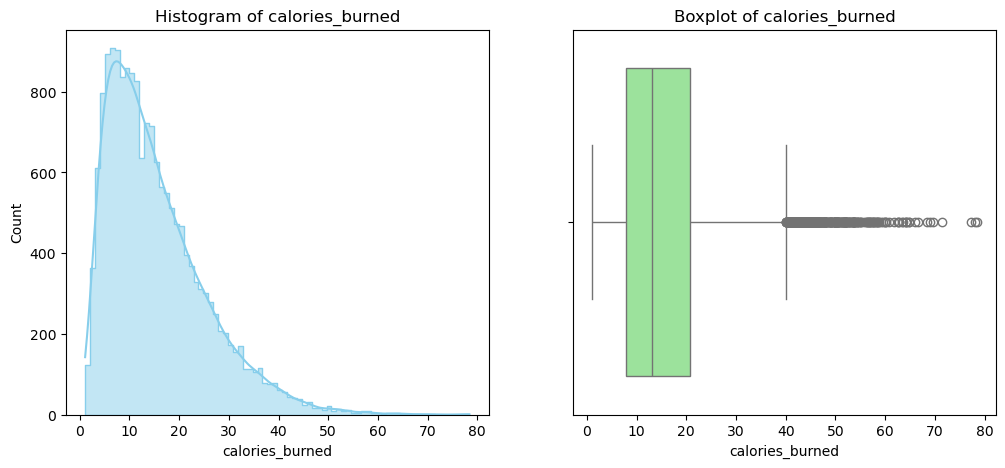

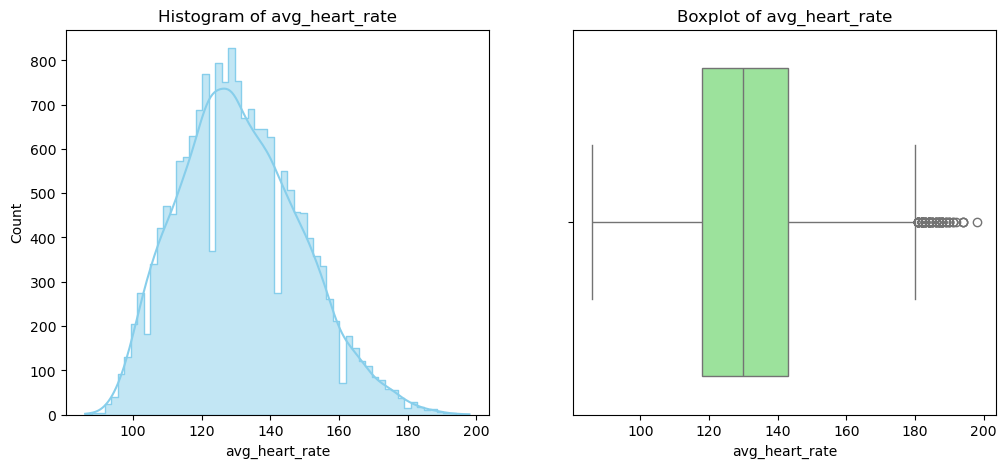

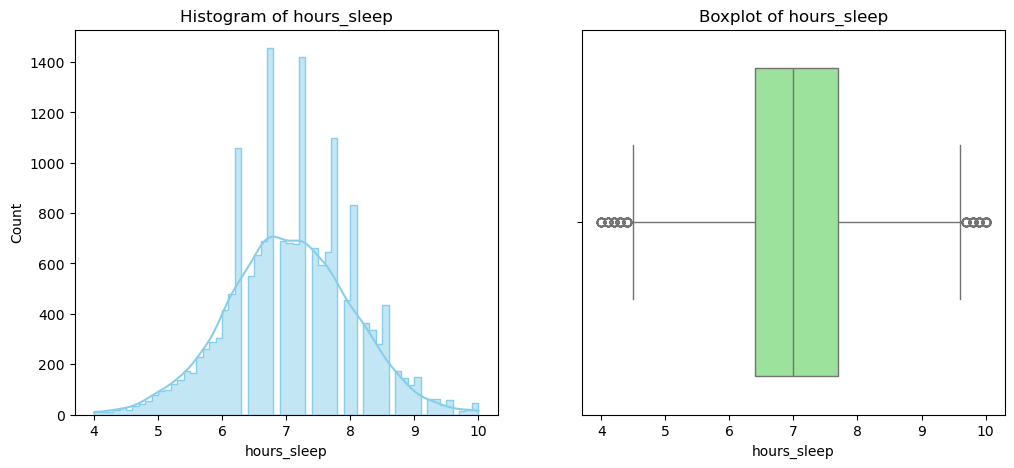

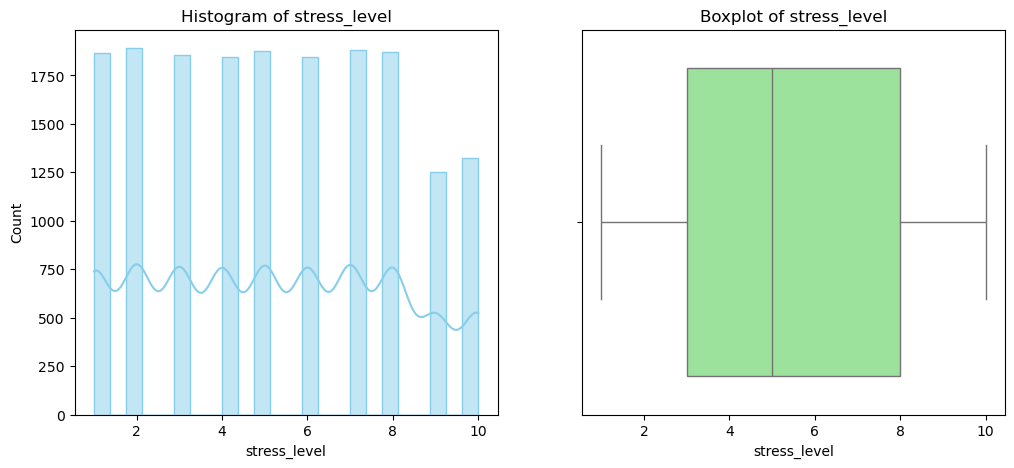

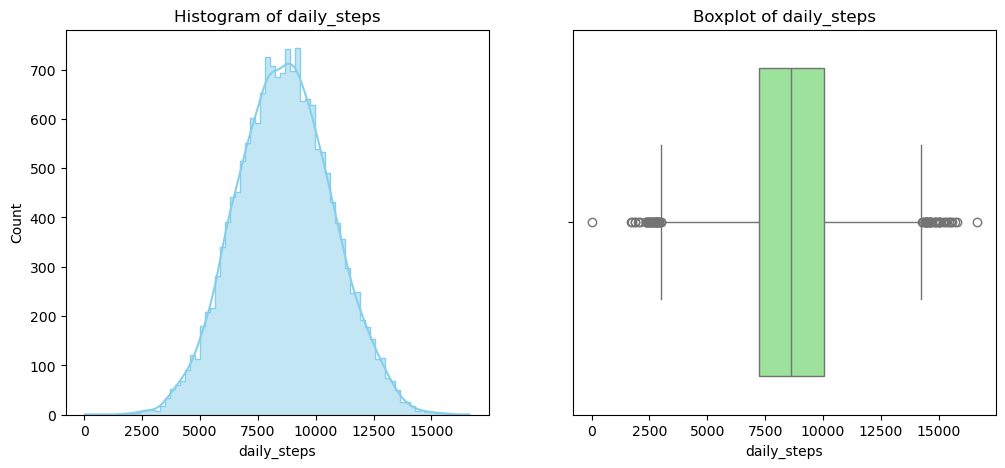

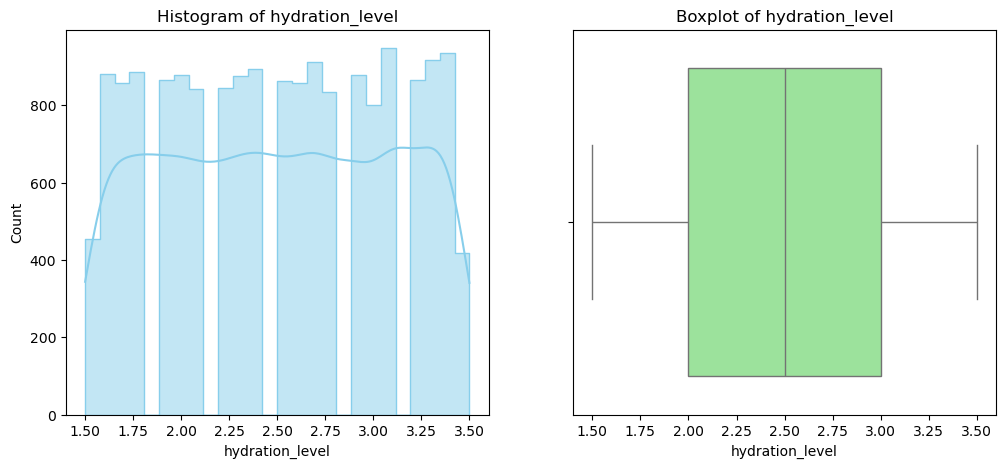

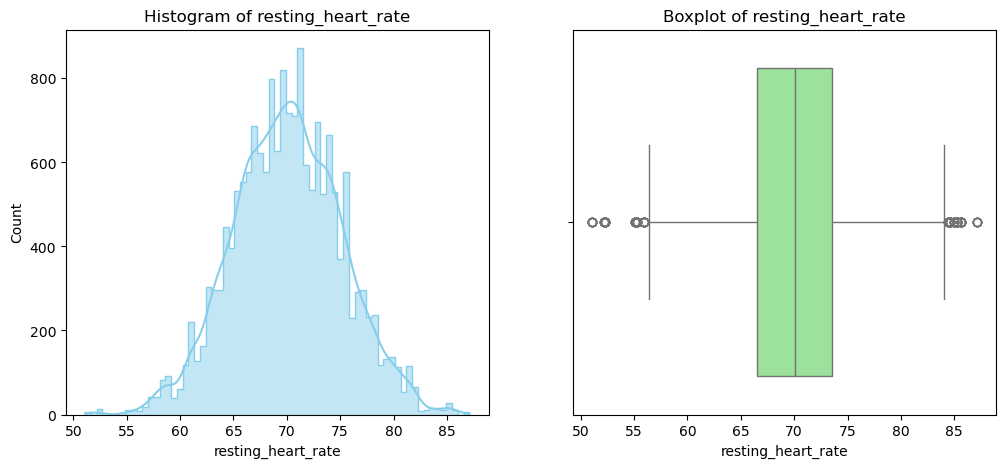

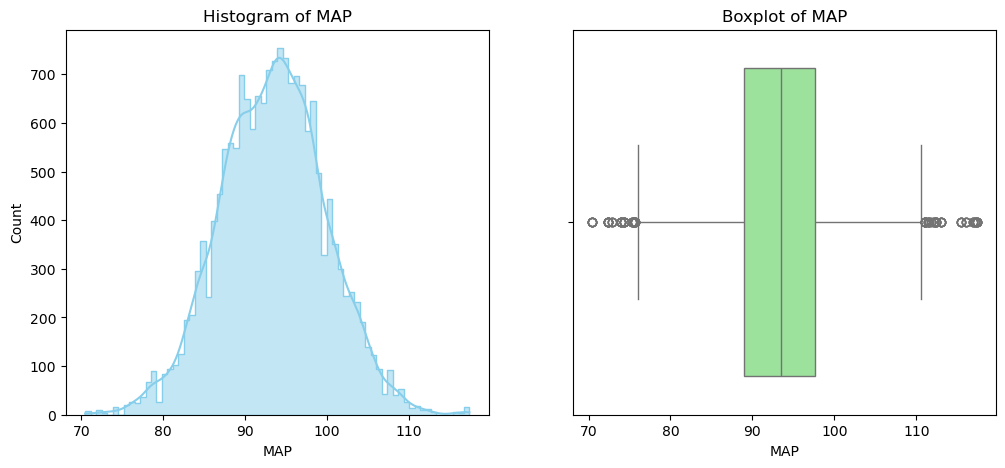

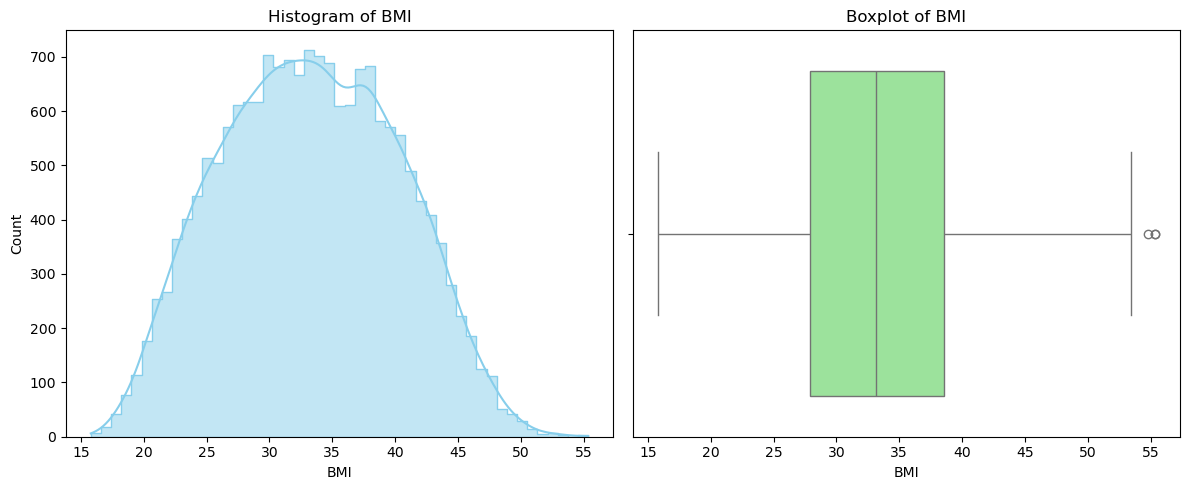

In [41]:
##Numerical Histograms and Box Plot for predictor variables
for var in numerical_features.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Histogram
    sns.histplot(data=X_train, x=var, kde=True, ax=axes[0], color='skyblue', element="step")
    axes[0].set_title(f"Histogram of {var}")
    
    # Boxplot
    sns.boxplot(data=X_train, x=var, ax=axes[1], color='lightgreen')
    axes[1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()
    

Histogram of Age
*The histogram shows a relatively uniform distribution of ages ranging from around 18 to 65.
*There are no extreme peaks or dips, suggesting that the sample is quite evenly spread across different age groups.
Boxplot of Age 
*No significant outliers are present

Histogram of duration_minutes
*The session durations range from about 20 minutes to 120 minutes.
*The histogram shows a fairly uniform distribution
*Small dips: There are noticeable dips at a few specific intervals (like around 50, 70, and 100 minutes), which could indicate:(Fewer sessions logged at those specific durations.Possible data entry gaps or natural user behavior preferences avoiding those timeframes.)
Boxplot of duration_minutes
*No significant outliers are present
*median is around 70 minutes, showing that half the sessions are shorter and half are longer than that.

Histogram of calories_burned
*This is a right-skewed (positively skewed) distribution.
*Most of the activity sessions burn between 5 and 15 calories, with the highest frequency around 10 calories.
Boxplot of calories_burned
*Median is falls around 15–17 calories, meaning over half the sessions burn fewer than this.
*A large number of outliers exist beyond 40 calories — these are valid but rare, representing high-calorie-burn sessions.
*This is a classic pattern seen in fitness apps, especially those catering to a general population:
****Majority of users might be beginners or opting for low-commitment activities.
****The few outliers might be fitness enthusiasts, athletes, or people with specific training goals.

Histogram of avg_heart_rate
*The histogram shows a distribution that is close to normal (bell-shaped), but it's slightly left-skewed (negative skew), as there's a bit of a tail toward the lower heart rates.
*The mode seems to be around 125–135 bpm (beats per minute), which is where the most frequent heart rate readings lie.
Boxplot of avg_heart_rate
*The median heart rate is around 130 bpm.
*There are several outliers above ~180 bpm, indicating that a few sessions involved unusually high heart rates.
*Outliers above 180 bpm could be from:(High-intensity interval training (HIIT),Younger individuals with high heart rate capacity Or possibly data errors or faulty readings.)
*Very high average heart rates (over 180 bpm) could be risky for some individuals, especially those with cardiovascular conditions. This highlights the importance of personalized fitness plans based on medical history.

Histogram of hours_sleep
*This distribution is slightly right-skewed, meaning most people sleep fewer hours, with fewer people sleeping longer (above 8 hours).
*The highest peak is around 7 hours, meaning that’s the most common sleep duration.
*Sleep durations mostly fall between 5.5 to 9 hours, with a few cases below 5 or above 9.
Boxplot of hours_sleep
*median is around 7.1 hours, which aligns with health recommendations
*Some people are sleeping less than 5 or more than 9 hours, which are flagged as outliers.
*The recommended sleep duration for adults is typically 7 to 9 hours per night.This data suggests that most people in the dataset are within that range, which is encouraging.
*People sleeping less than 6 hours may be at risk of:(Cognitive decline,Lower productivity,Increased risk of heart disease, obesity, and diabetes)
*Sleep durations above 9 hours might be linked to:(Excessive fatigue,Depression,Underlying health conditions,Or they may just represent younger individuals or rest days)

Histogram of stress_level
*The bars from 1 to 8 are fairly consistent in height, suggesting that stress levels are evenly distributed across the population.
*However, there's a noticeable drop at levels 9 and 10, indicating fewer people report extremely high stress.
Boxplot of stress_level
*Median is roughly 5.5, right in the middle of the scale, indicating moderate average stress.
*No major outliers

Histogram of daily_steps
*The data appears to be approximately normally distributed
*The peak (most frequent value) is around 7,500-10,000 steps
Boxplot of daily_steps
*some outliers at both ends.
*The median (vertical line in the box) appears to be around 7,500-8,000 steps

Histogram of hydration_level
*The distribution appears relatively uniform across the different hydration level values
*No visible outliers are shown

Histogram of resting_heart_rate
*The distribution appears to be roughly normal (bell-shaped)
*The peak frequency occurs around 70-72 bpm
Boxplot of resting_heart_rate
*The median (vertical line in the box) is around 70 bpm
*There are several outliers visible at both the lower and upper ends of the distribution

MAP
*The data appears to be approximately normally distributed
*There are several outliers visible at both the lower and upper ends of the distribution

BMI
*The data appears to be approximately normally distributed
*outliers can  be identify

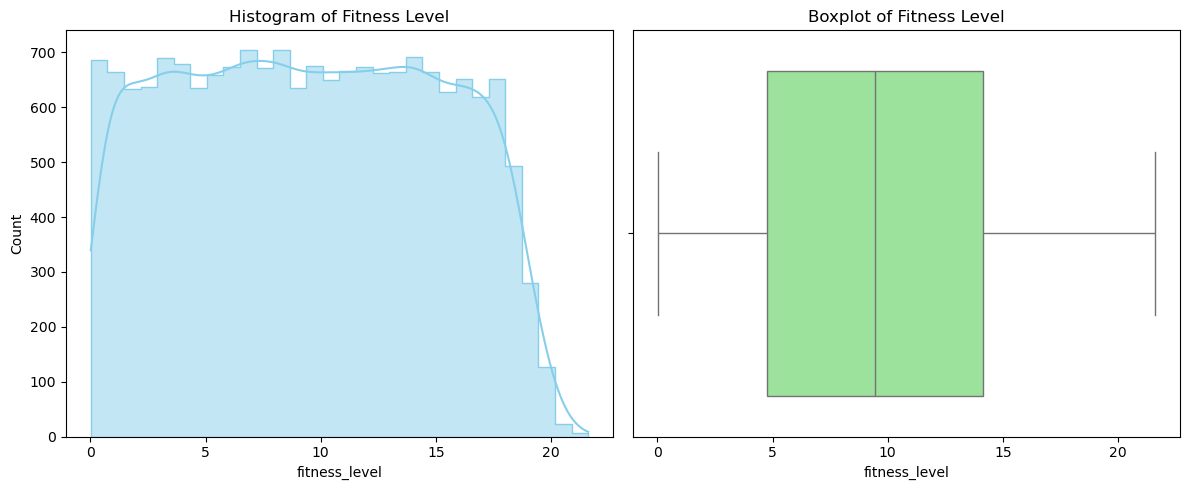

In [43]:
##Numerical histogram and Box plot for Target varible
# Create a figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

Y_train=pd.DataFrame(Y_train)
# Histogram
sns.histplot(data=Y_train, x="fitness_level", kde=True, ax=axes[0], color='skyblue', element="step")
axes[0].set_title(f"Histogram of {"Fitness Level"}")

# Boxplot
sns.boxplot(data=Y_train, x="fitness_level", ax=axes[1], color='lightgreen')
axes[1].set_title(f"Boxplot of {"Fitness Level"}")

plt.tight_layout()
plt.show()

Histogram
*Shows fitness level values ranging from approximately 0 to 20
*The distribution is quite unusual - it's relatively flat across most values (from about 2-18) with counts consistently between 650-700
*The frequency drops off sharply after 18

Boxplot
*The median (vertical line) is around 10
*No visible outliers are shown



C:\Users\ASUS\AppData\Local\Temp\ipykernel_14420\2445367943.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x=var, y="count", palette="muted", ax=axes[i])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14420\2445367943.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x=var, y="count", palette="muted", ax=axes[i])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14420\2445367943.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x=var, y="count", palette="muted", ax=axes[i])
C:\Users\ASUS\AppData\Local\

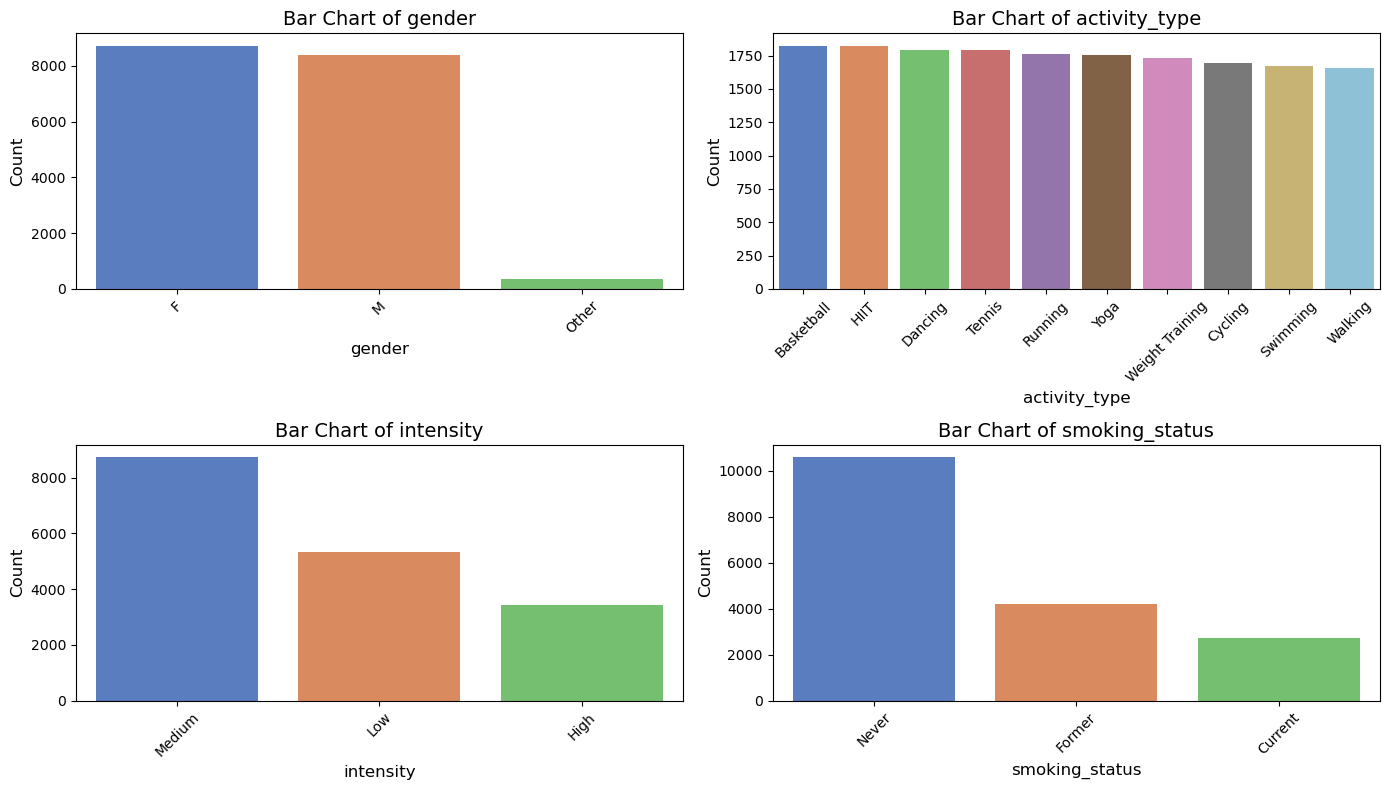

In [45]:
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # <- important fix!

for i, var in enumerate(categorical_cols):
    counts = X_train[var].value_counts().reset_index()
    counts.columns = [var, "count"]

    sns.barplot(data=counts, x=var, y="count", palette="muted", ax=axes[i])
    axes[i].set_title(f"Bar Chart of {var}", fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Gender
*Females and males have similar counts (around 8,000-8,500 each)
*The "other" category has a much smaller count (around 400)

The "other" gender category typically represents:
*People who identify as non-binary, genderqueer, genderfluid, or with other gender identities outside the traditional male/female binary
*People who are transgender and may choose to identify in a separate category
*People who prefer not to disclose their gender or don't align with traditional gender categories
*Williams Institute (UCLA) Survey (2022) found that approximately 1.2 million adults in the US (about 0.5% of adults) identify as non-binary. Among LGBTQ+ adults aged 18-29, about 26% identified as non-binary.
*Journal of Adolescent Health study (2018): In a sample of over 80,000 Minnesota students, about 2.7% reported transgender or gender non-conforming identities.
*American Journal of Public Health (2017): A systematic review of population-based surveys estimated transgender identity at approximately 0.3-0.6% of the adult population.

Activity Type
*All activities have similar representation (approximately 1,700 participants each)
*This suggests an intentionally balanced study design rather than natural distribution
*In real-world scenarios, walking and running would typically be more common than activities like HIIT or tennis

Intensity - intensity typically describes how hard the body is working during physical activity.
*Medium intensity is most common

Smoking Status
*"Never" smokers form the largest group

Bivariate Analysis

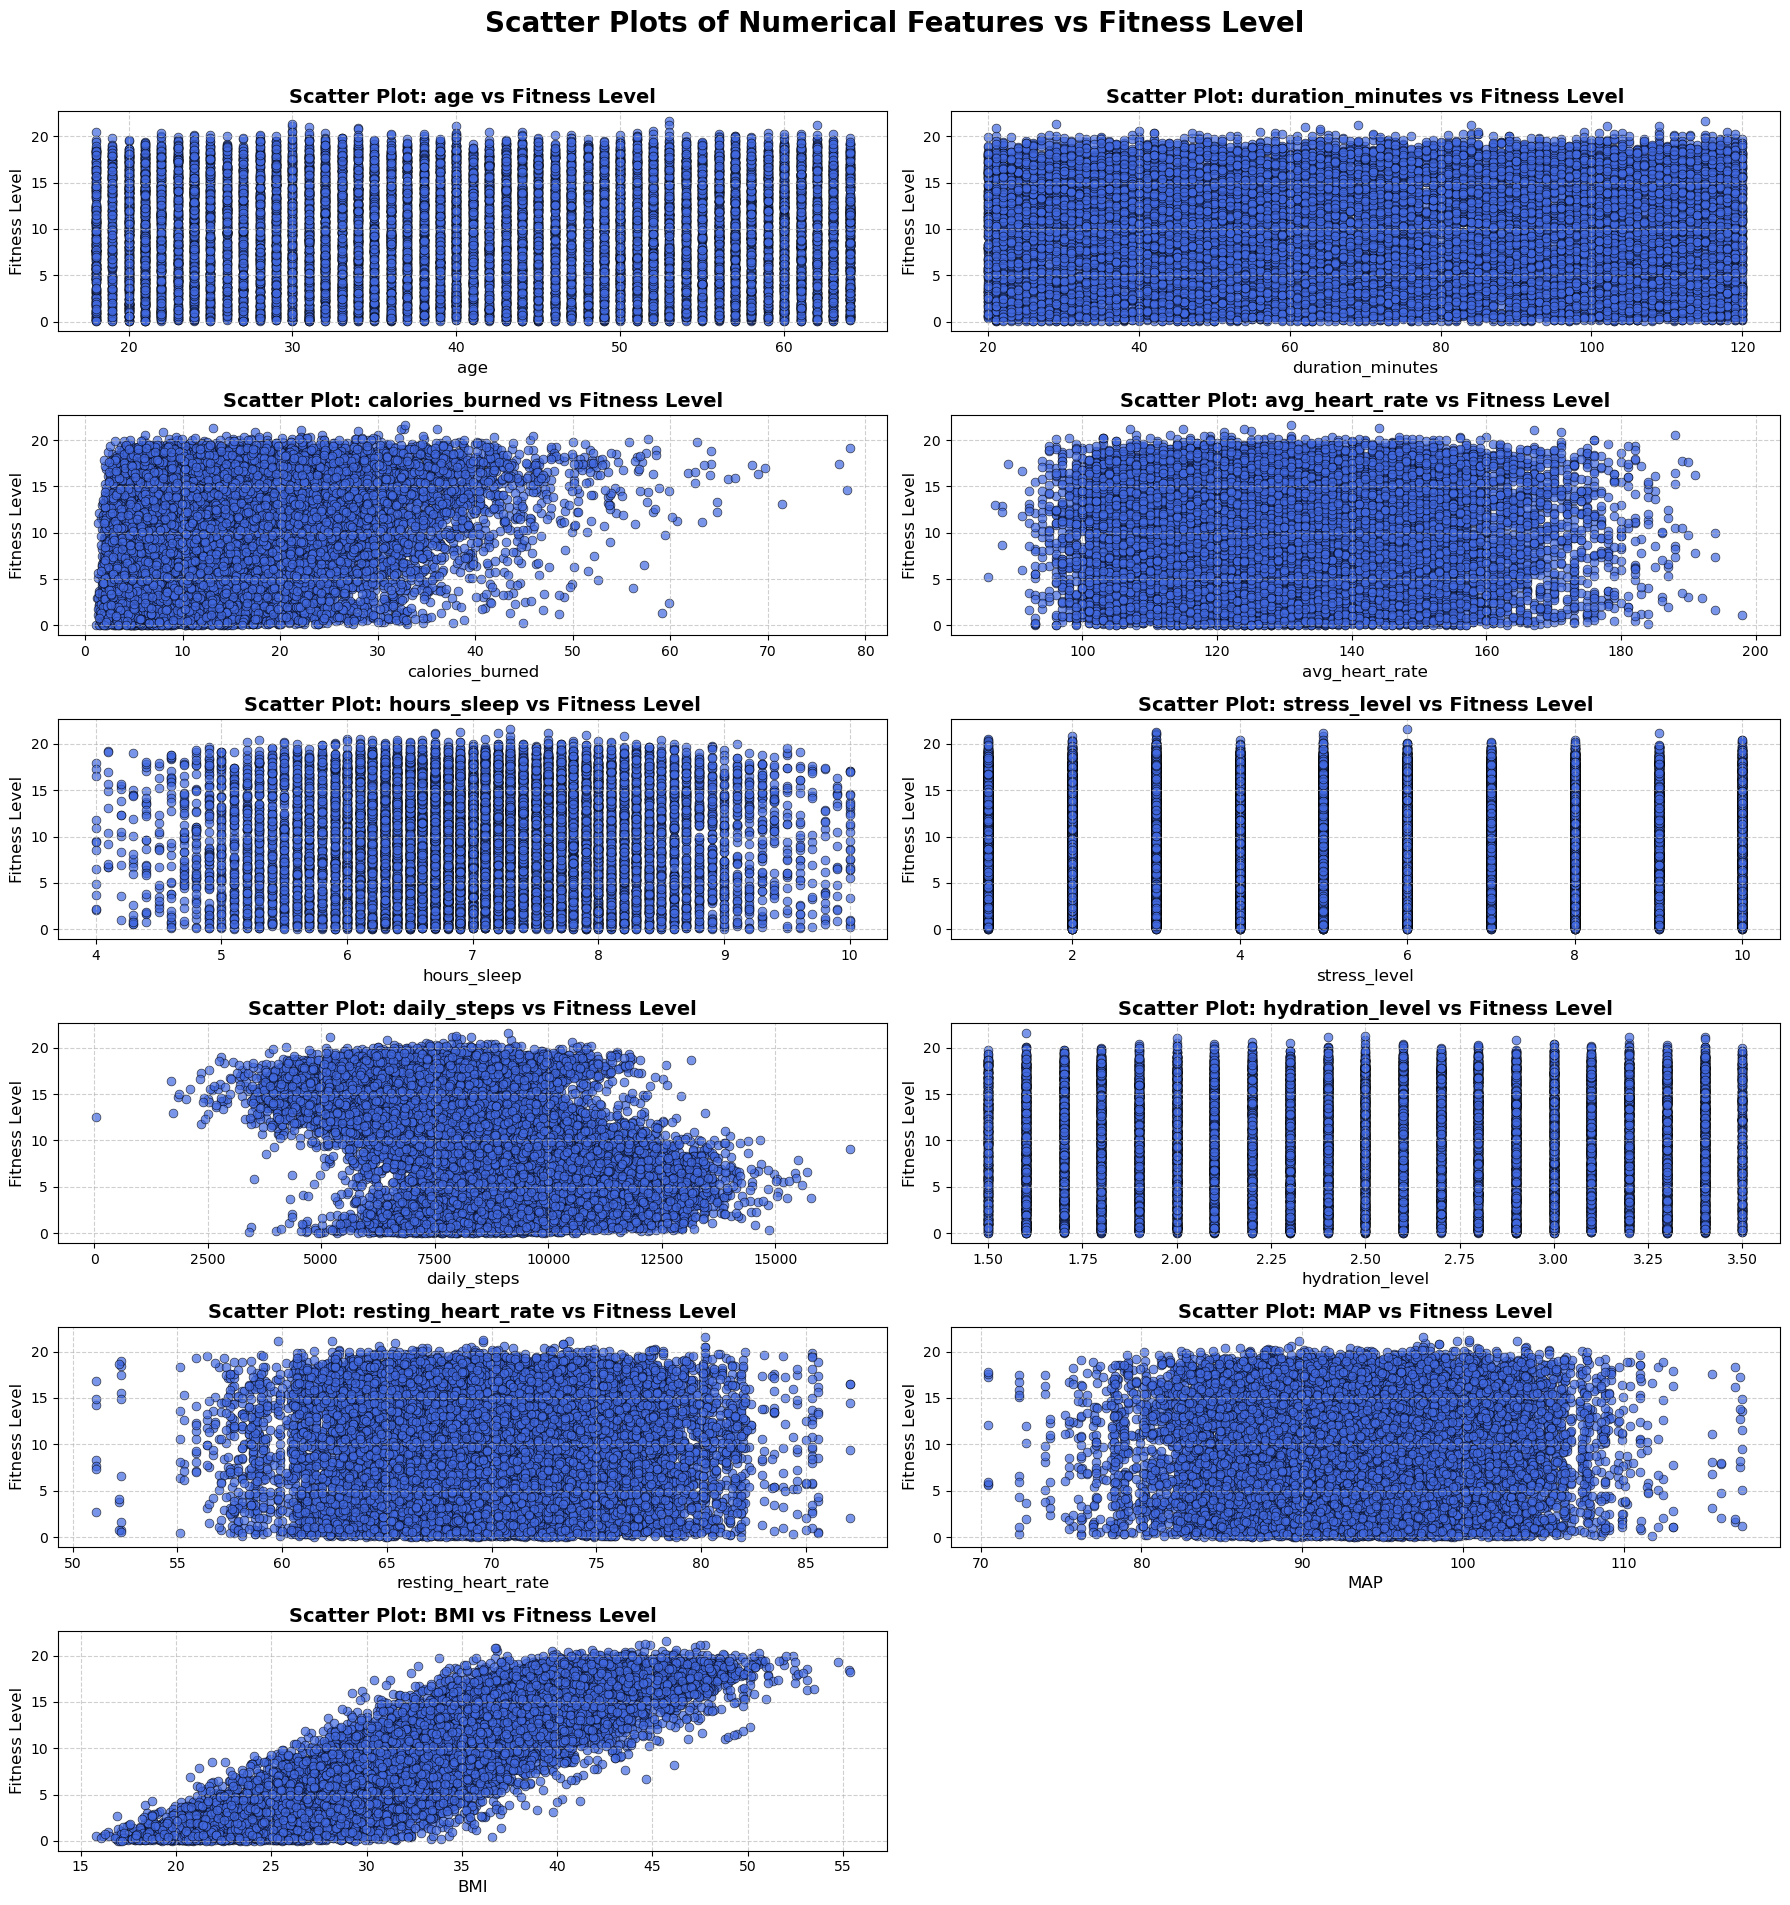

In [48]:
##Scatter Plot with target variable and numerical predictors
# Create subplots
# Create subplots
fig, axes = plt.subplots(6, 2, figsize=(18, 20))
axes = axes.flatten()

Y_var = Y_train.squeeze()  # <-- flatten the target variable

for i, var in enumerate(numerical_features):
    sns.scatterplot(
        x=X_train[var], y=Y_var,
        color='royalblue', s=40, alpha=0.7, edgecolor='k', ax=axes[i]
    )
    axes[i].set_title(f"Scatter Plot: {var} vs Fitness Level", fontsize=14, weight='bold')
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Fitness Level', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Scatter Plots of Numerical Features vs Fitness Level', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

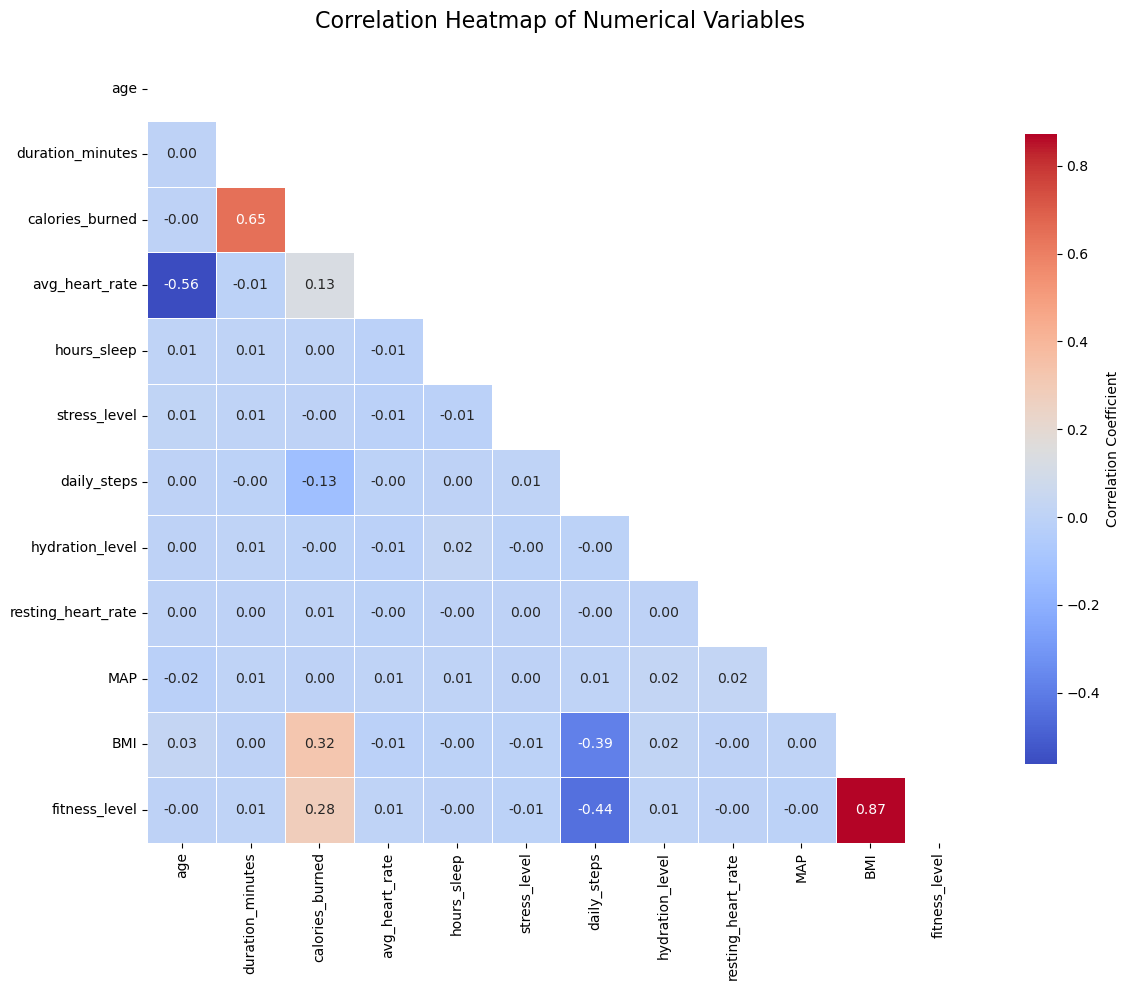

In [49]:
##correlation Heatmap with numerical variables
# Calculate the correlation matrix
train_data = pd.concat([X_train, Y_train], axis=1)
correlation_matrix = train_data.select_dtypes(include='number').corr()

# Create a figure with appropriate size
plt.figure(figsize=(12, 10))

# Create a mask for the upper triangle to avoid redundancy
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,  # Show correlation values
            fmt='.2f',   # Format as 2 decimal places
            cmap='coolwarm',  # Color map (red for negative, blue for positive)
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'})

# Add title
plt.title('Correlation Heatmap of Numerical Variables', fontsize=16, pad=20)

# Adjust layout
plt.tight_layout()

BMI and fitness_level have high positive correlation.
WHO emphasizes maintaining a normal BMI and engaging in regular physical activity as key components of a healthy lifestyle. 
Body Mass Index and Physical Fitness in Brazilian Adolescents: This study examined the relationship between BMI and physical fitness among Brazilian adolescents. The findings indicated that higher BMI was associated with lower physical fitness levels in this population. 

duration_minutes and calories_burned have moderate positive correlation

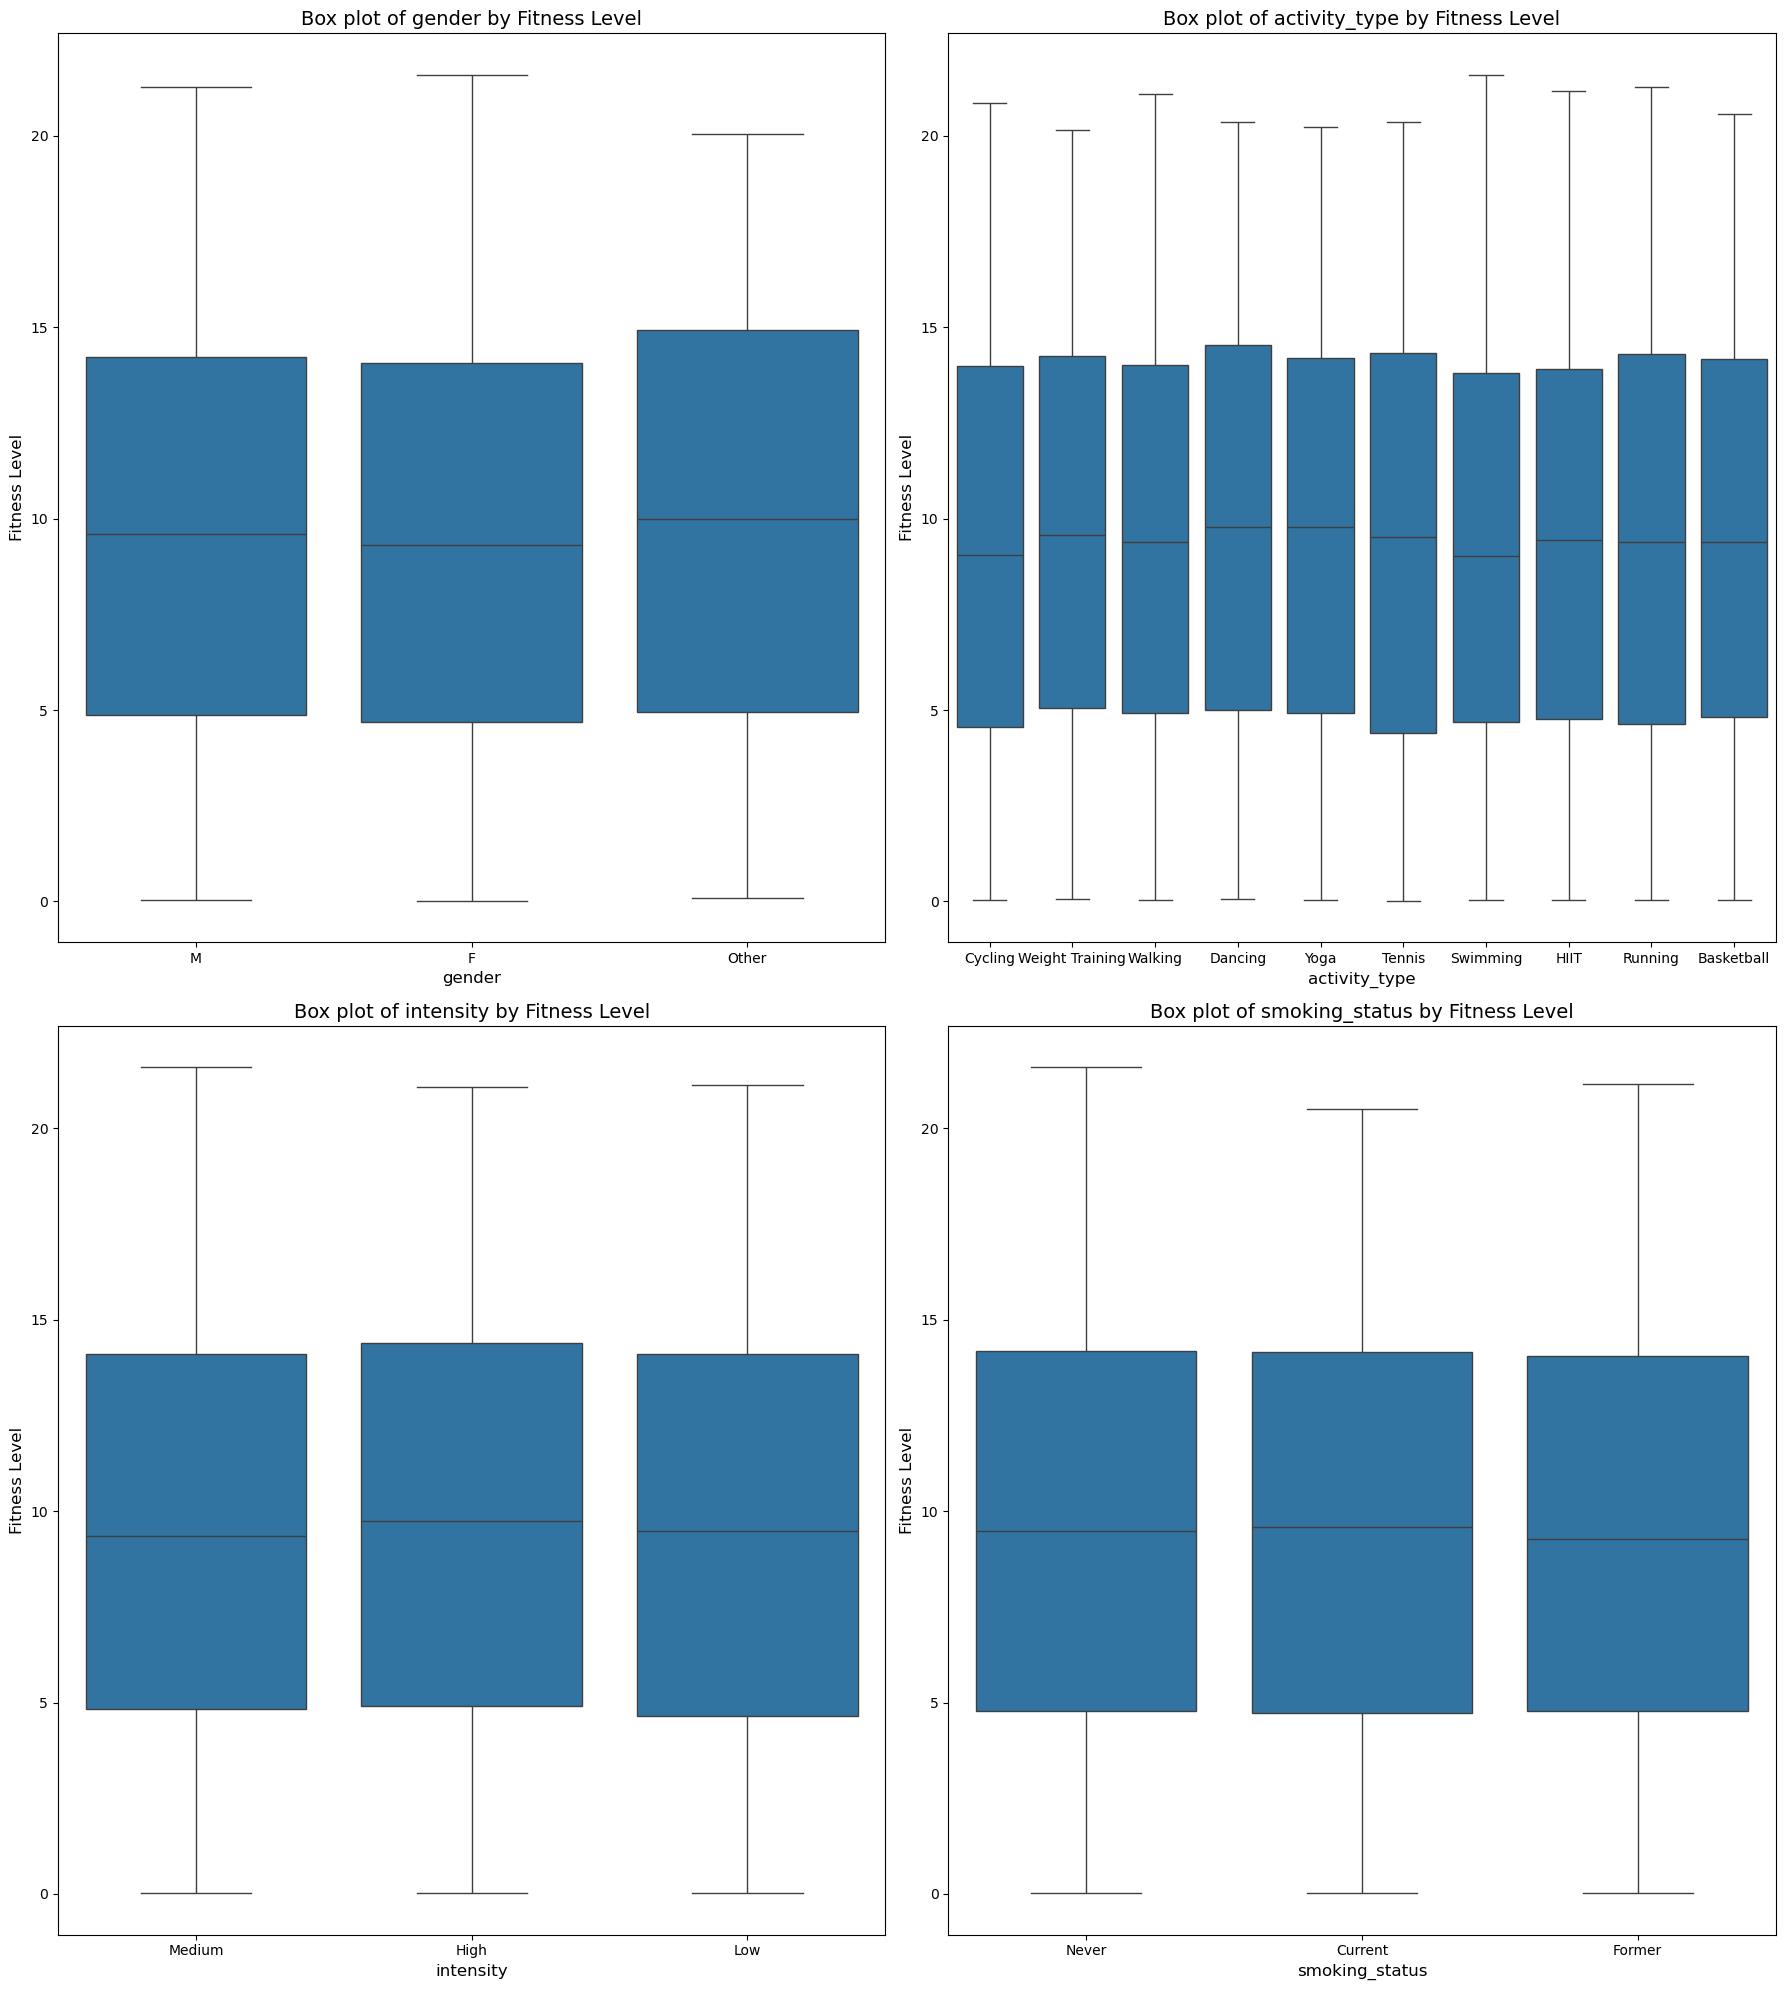

In [51]:
##Box Plot with Target Variable and Categorical Variable

fig, axes = plt.subplots(2, 2, figsize=(18, 20))

for i, var in enumerate(categorical_cols):
    row = i // 2
    col = i % 2

    sns.boxplot(x=train_data[var], y=train_data['fitness_level'], data=train_data, ax=axes[row, col])

    axes[row, col].set_title(f"Box plot of {var} by Fitness Level", fontsize=14)
    axes[row, col].set_xlabel(var, fontsize=12)
    axes[row, col].set_ylabel('Fitness Level', fontsize=12)

plt.tight_layout()
plt.show()

Group M: Shapiro-Wilk Test p-value = 0.0000
Group F: Shapiro-Wilk Test p-value = 0.0000
Group Other: Shapiro-Wilk Test p-value = 0.0000


C:\Users\ASUS\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


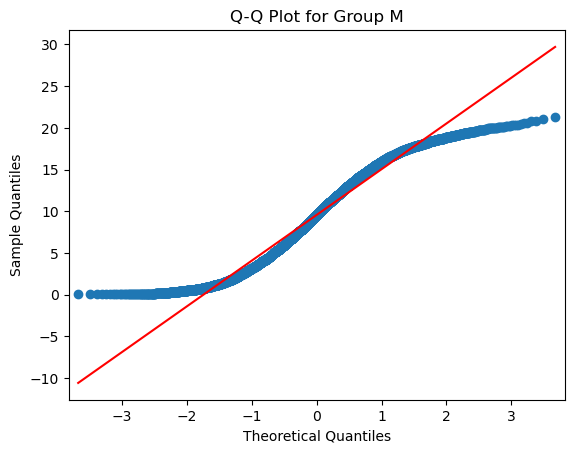

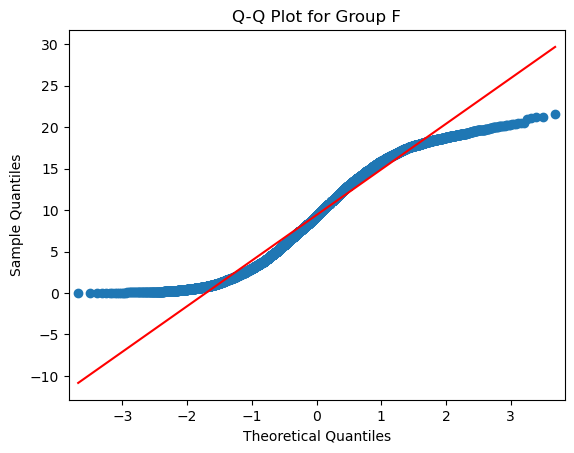

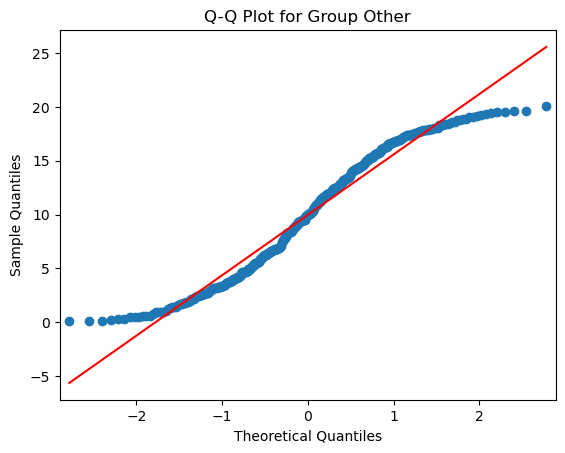

Levene’s Test p-value = 0.5808


In [52]:
#One way ANOVA
#gender
#Assumptions
#normality within groups

groups = train_data['gender'].unique()
for g in groups:
    group_data = train_data[train_data['gender'] == g]['fitness_level']
    stat, p = stats.shapiro(group_data)
    print(f"Group {g}: Shapiro-Wilk Test p-value = {p:.4f}")

#If p > 0.05, the group data is likely normally distributed.

for g in groups:
    sm.qqplot(train_data[train_data['gender'] == g]['fitness_level'], line='s')
    plt.title(f"Q-Q Plot for Group {g}")
    plt.show()
    
#Homogenity of variance within groups
stat, p = stats.levene(*[train_data[train_data['gender'] == g]['fitness_level'] for g in groups])
print(f"Levene’s Test p-value = {p:.4f}")

#If p > 0.05, variances are equal 

In [53]:
#gender
from scipy.stats import kruskal
import scikit_posthocs as sp

#Kruskal-Wallis Test
groups = [train_data[train_data['gender'] == g]['fitness_level'] for g in train_data['gender'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {stat:.4f}, p-value = {p:.4f}")


Kruskal-Wallis H-statistic = 5.8171, p-value = 0.0546


Group Cycling: Shapiro-Wilk Test p-value = 0.0000
Group Weight Training: Shapiro-Wilk Test p-value = 0.0000
Group Walking: Shapiro-Wilk Test p-value = 0.0000
Group Dancing: Shapiro-Wilk Test p-value = 0.0000
Group Yoga: Shapiro-Wilk Test p-value = 0.0000
Group Tennis: Shapiro-Wilk Test p-value = 0.0000
Group Swimming: Shapiro-Wilk Test p-value = 0.0000
Group HIIT: Shapiro-Wilk Test p-value = 0.0000
Group Running: Shapiro-Wilk Test p-value = 0.0000
Group Basketball: Shapiro-Wilk Test p-value = 0.0000


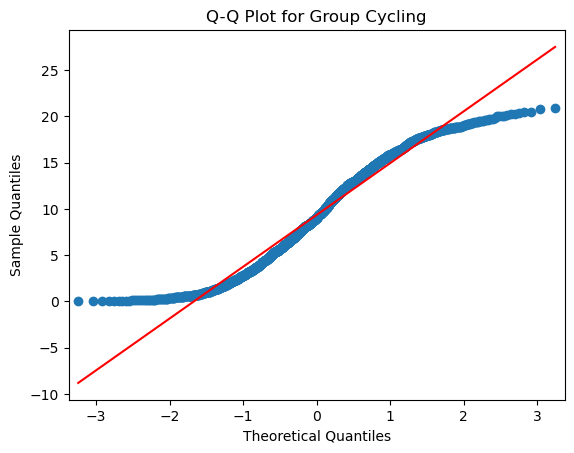

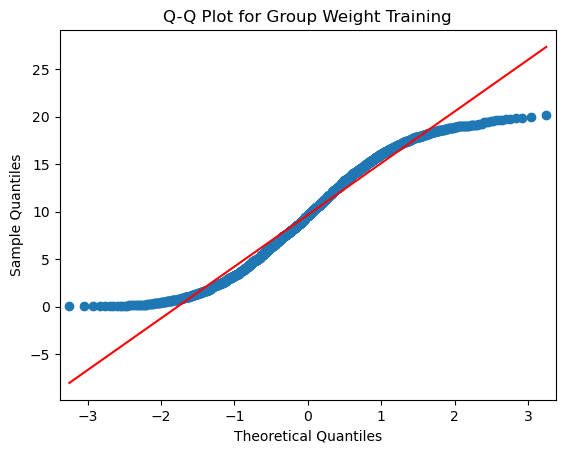

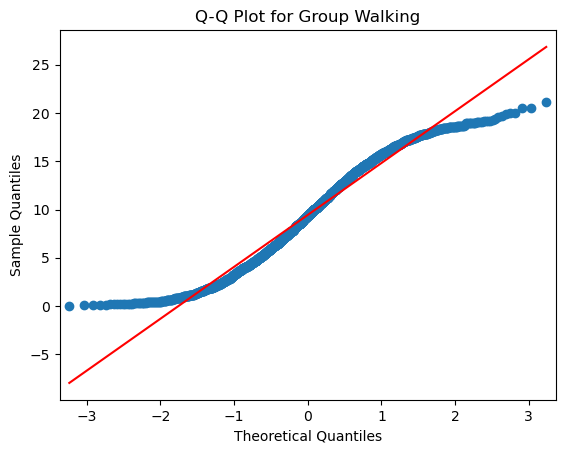

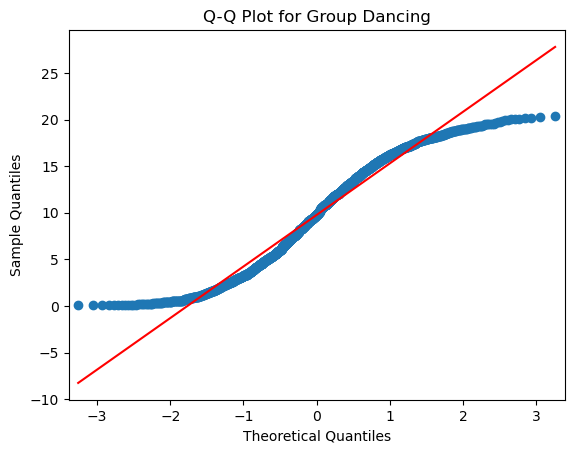

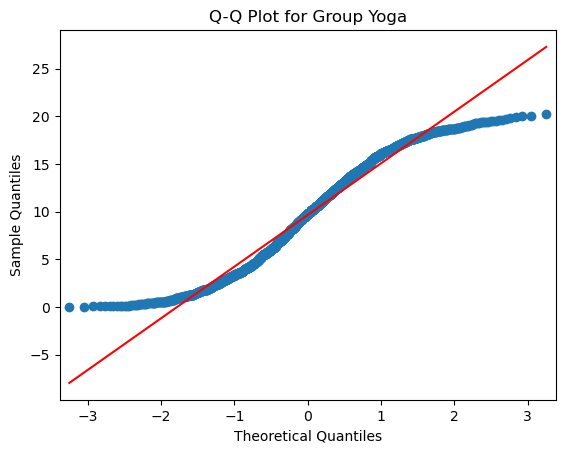

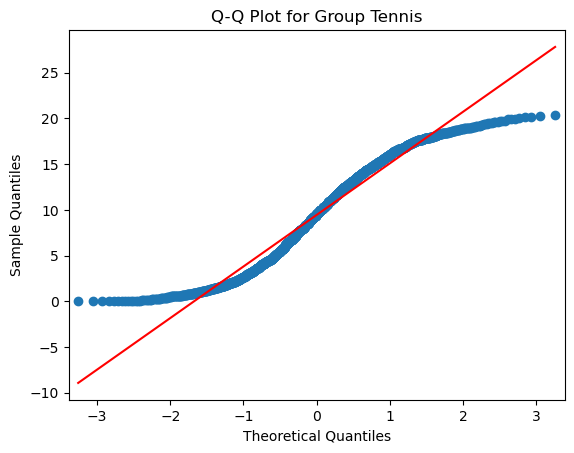

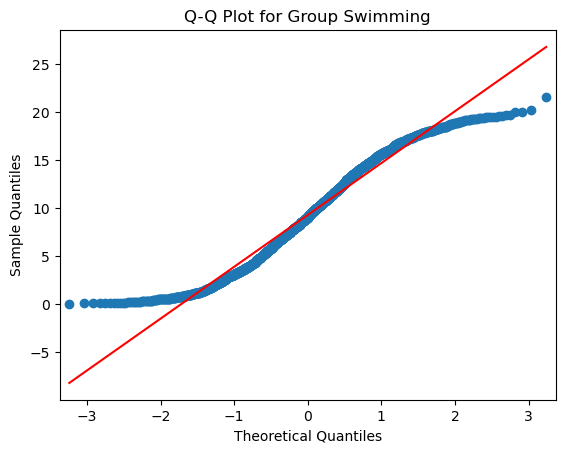

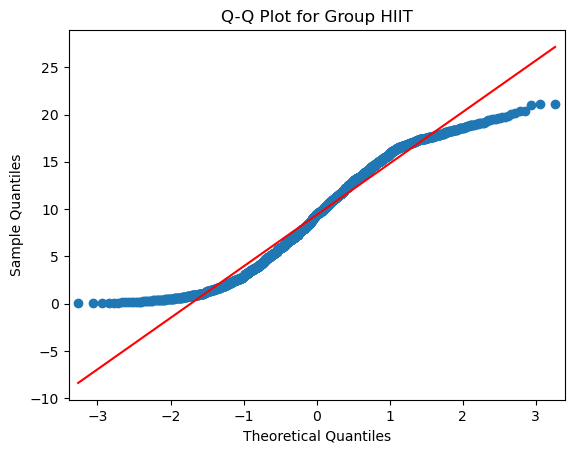

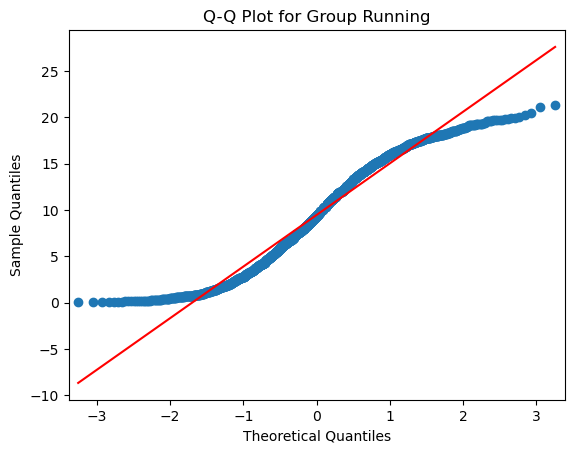

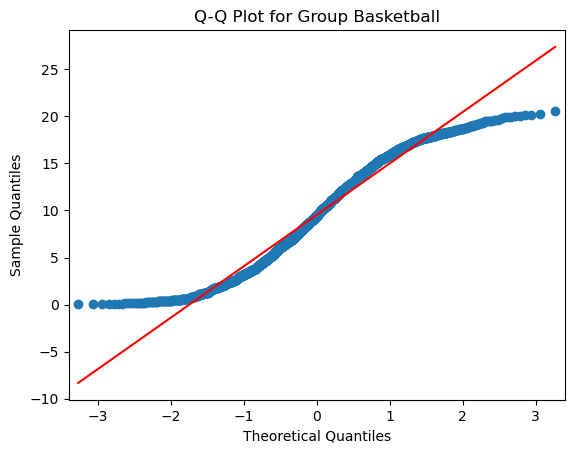

Levene’s Test p-value = 0.0242


In [54]:
##activity_type
#Assumptions
#normality within groups

groups = train_data['activity_type'].unique()
for g in groups:
    group_data = train_data[train_data['activity_type'] == g]['fitness_level']
    stat, p = stats.shapiro(group_data)
    print(f"Group {g}: Shapiro-Wilk Test p-value = {p:.4f}")

#If p > 0.05, the group data is likely normally distributed.

for g in groups:
    sm.qqplot(train_data[train_data['activity_type'] == g]['fitness_level'], line='s')
    plt.title(f"Q-Q Plot for Group {g}")
    plt.show()
    
#Homogenity of variance within groups
stat, p = stats.levene(*[train_data[train_data['activity_type'] == g]['fitness_level'] for g in groups])
print(f"Levene’s Test p-value = {p:.4f}")

#If p > 0.05, variances are equal 

In [55]:
#activity_type
#Kruskal-Wallis Test
groups = [train_data[train_data['activity_type'] == g]['fitness_level'] for g in train_data['activity_type'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {stat:.4f}, p-value = {p:.4f}")

Kruskal-Wallis H-statistic = 12.3289, p-value = 0.1954


Group Never: Shapiro-Wilk Test p-value = 0.0000
Group Current: Shapiro-Wilk Test p-value = 0.0000
Group Former: Shapiro-Wilk Test p-value = 0.0000


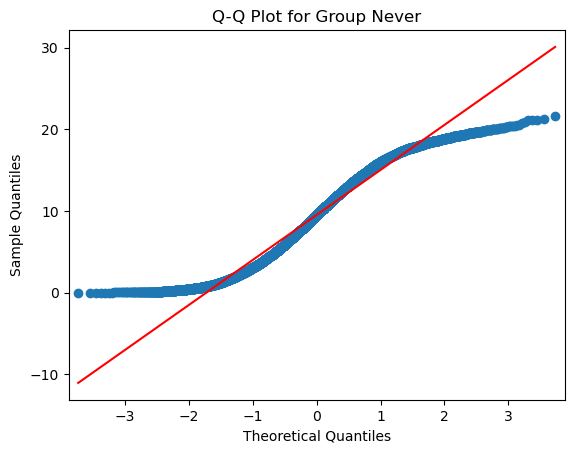

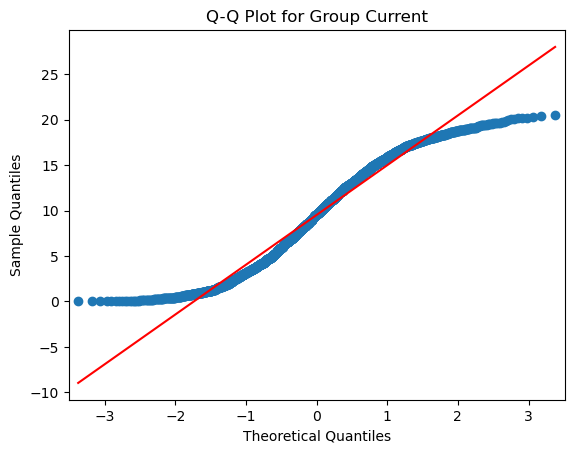

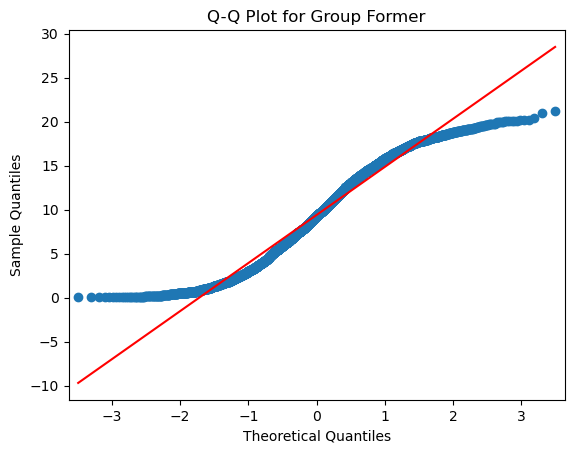

Levene’s Test p-value = 0.6266


In [56]:
#smoking_status
#Assumptions
#normality within groups

groups = train_data['smoking_status'].unique()
for g in groups:
    group_data = train_data[train_data['smoking_status'] == g]['fitness_level']
    stat, p = stats.shapiro(group_data)
    print(f"Group {g}: Shapiro-Wilk Test p-value = {p:.4f}")

#If p > 0.05, the group data is likely normally distributed.

for g in groups:
    sm.qqplot(train_data[train_data['smoking_status'] == g]['fitness_level'], line='s')
    plt.title(f"Q-Q Plot for Group {g}")
    plt.show()
    
#Homogenity of variance within groups
stat, p = stats.levene(*[train_data[train_data['smoking_status'] == g]['fitness_level'] for g in groups])
print(f"Levene’s Test p-value = {p:.4f}")

#If p > 0.05, variances are equal 

In [57]:
#smoking_status
#Kruskal-Wallis Test
groups = [train_data[train_data['smoking_status'] == g]['fitness_level'] for g in train_data['smoking_status'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {stat:.4f}, p-value = {p:.4f}")

Kruskal-Wallis H-statistic = 1.8222, p-value = 0.4021


Group Medium: Shapiro-Wilk Test p-value = 0.0000
Group High: Shapiro-Wilk Test p-value = 0.0000
Group Low: Shapiro-Wilk Test p-value = 0.0000


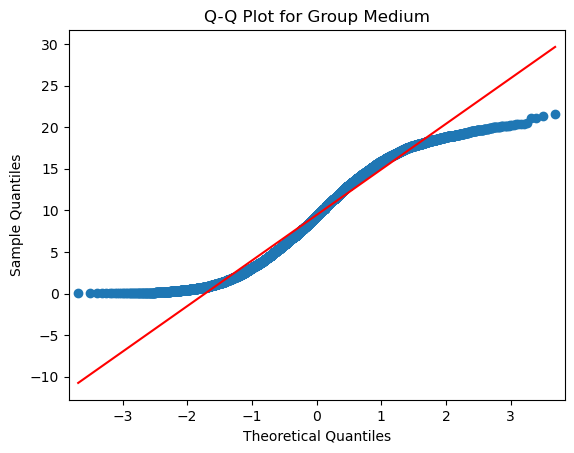

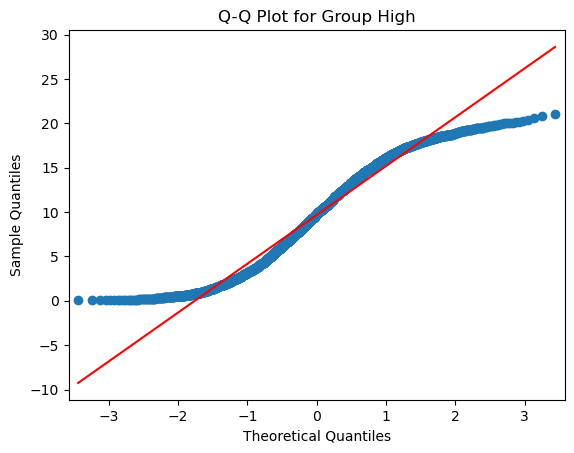

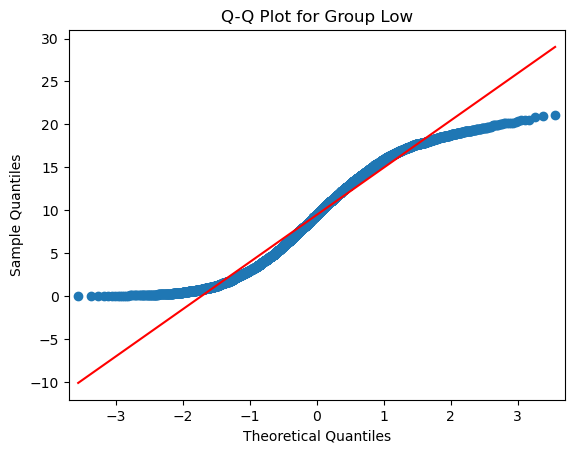

Levene’s Test p-value = 0.8531


In [58]:
#intensity
#Assumptions
#normality within groups

groups = train_data['intensity'].unique()
for g in groups:
    group_data = train_data[train_data['intensity'] == g]['fitness_level']
    stat, p = stats.shapiro(group_data)
    print(f"Group {g}: Shapiro-Wilk Test p-value = {p:.4f}")

#If p > 0.05, the group data is likely normally distributed.

for g in groups:
    sm.qqplot(train_data[train_data['intensity'] == g]['fitness_level'], line='s')
    plt.title(f"Q-Q Plot for Group {g}")
    plt.show()
    
#Homogenity of variance within groups
stat, p = stats.levene(*[train_data[train_data['intensity'] == g]['fitness_level'] for g in groups])
print(f"Levene’s Test p-value = {p:.4f}")

#If p > 0.05, variances are equal 

In [59]:
#intensity
#Kruskal-Wallis Test
groups = [train_data[train_data['intensity'] == g]['fitness_level'] for g in train_data['intensity'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {stat:.4f}, p-value = {p:.4f}")

Kruskal-Wallis H-statistic = 4.4083, p-value = 0.1103


** all p values >0.05 in kruskal wallist test. so no evidence of group differences in each categorical variable

In [61]:
#gender &activity_type
crosstab = pd.crosstab(train_data['gender'], train_data['activity_type'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")
#p < 0.05 → Significant association.

Chi2 Statistic: 35.45, p-value: 0.0083


In [62]:
#gender &smoking_status
crosstab = pd.crosstab(train_data['gender'], train_data['smoking_status'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi2 Statistic: 18.57, p-value: 0.0010


In [63]:
#gender &intensity
crosstab = pd.crosstab(train_data['gender'], train_data['intensity'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi2 Statistic: 0.40, p-value: 0.9823


In [64]:
#activity_type & smoking_status
crosstab = pd.crosstab(train_data['activity_type'], train_data['smoking_status'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi2 Statistic: 20.68, p-value: 0.2958


In [65]:
#activity_type & intensity
crosstab = pd.crosstab(train_data['activity_type'], train_data['intensity'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi2 Statistic: 9.94, p-value: 0.9339


In [66]:
#smoking_status & intensity
crosstab = pd.crosstab(train_data['smoking_status'], train_data['intensity'])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi2 Statistic: 0.11, p-value: 0.9987


** gender and smoking status significally associated

Multivariate Analysis

In [69]:
# Calculate VIF values for each feature in the dataset
def calculate_vif(X):
    # Create a DataFrame to store VIF values
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Sort by VIF values (optional)
    return vif_data.sort_values("VIF", ascending=False)

# Make sure X_train contains only numeric columns
# If you have categorical columns, you might need to encode them first
# Remove any non-numeric columns if necessary
X_numeric = X_train.select_dtypes(include=[np.number])

# Calculate and display VIF values
vif_values = calculate_vif(X_numeric)
print(vif_values)

              Variable         VIF
9                  MAP  151.691684
8   resting_heart_rate  140.347150
3       avg_heart_rate   68.088271
4          hours_sleep   49.111435
10                 BMI   30.329606
6          daily_steps   20.879104
7      hydration_level   19.155384
0                  age   13.731963
1     duration_minutes   12.548062
2      calories_burned    7.232400
5         stress_level    4.546134


Multivariate Outliers for original dataset

In [71]:
##check the data follows MVN using Mardia's Test
multivariate_normality(X_train[numerical_features.columns], alpha=0.05)
##MVN assumption Failed

HZResults(hz=1.3002139320653294, pval=0.0, normal=False)

In [75]:
##Therefore,we use the Roubust Mahalanobias Distance to check the Multivariate outliers

# Robust covariance estimator
robust_cov = MinCovDet(random_state=42).fit(X_train[numerical_features.columns])

# Mahalanobis distances
mahal_dist_robust = robust_cov.mahalanobis(X_train[numerical_features.columns])

# Set a threshold (like chi-square quantile)
threshold = chi2.ppf(0.975, df=X_train[numerical_features.columns].shape[1])

# Outliers
outliers = np.where(mahal_dist_robust > threshold)[0]

print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 680


In [77]:
X_train['Mahalanobis_Distance']=mahal_dist_robust
X_train['outliers']=X_train['Mahalanobis_Distance']>threshold

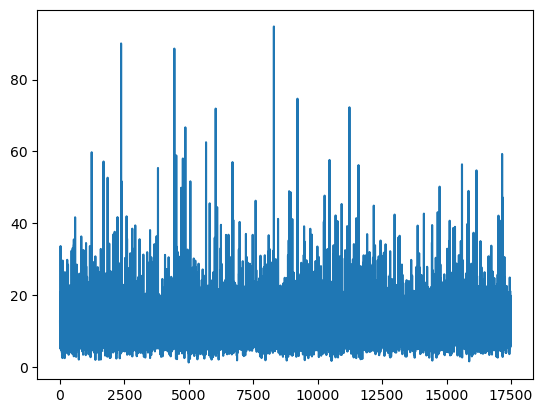

In [79]:
##visualize the Mahalanobias Distance
plt.plot(X_train['Mahalanobis_Distance'])

In [81]:
X_train['outliers'].value_counts()

outliers
False    16820
True       680
Name: count, dtype: int64

In [83]:
##Outliers
multivariate_outliers_data=X_train[X_train['outliers']==True]
multivariate_outliers_data

age gender activity_type  duration_minutes intensity  calories_burned  \
21      33      M          HIIT               109    Medium             51.8   
102     39      M          HIIT               120      High             49.1   
111     58      M       Running                94    Medium             41.7   
121     29      M        Tennis                90      High             38.4   
191     39      M       Cycling               108    Medium             47.8   
...    ...    ...           ...               ...       ...              ...   
17210   27      M          HIIT                80    Medium             43.5   
17247   61      M          HIIT                96    Medium             43.4   
17262   44      F          Yoga               101    Medium              6.9   
17333   64      F       Cycling               107    Medium             33.8   
17453   49      M       Cycling               106      High             44.8   

       avg_heart_rate  hours_sleep  stress_level  daily_steps  \
21                140          5.4             5         8082   
102               157          8.3             4        10530   
111               112          6.2             2         6699   
121               167          8.5             8         7578   
191               144          5.8             4         2805   
...               ...          ...           ...          ...   
17210             153          7.5            10         5532   
17247             106          6.5            10         5672   
17262             137          5.3             6        10844   
17333             115          9.3            10        12057   
17453             149          7.9             1         5612   

       hydration_level  resting_heart_rate smoking_status     MAP    BMI  \
21                 3.3                73.5          Never   85.07  42.36   
102                2.7                73.1          Never  100.27  29.27   
111                3.4                72.7        Current   98.77  43.81   
121                1.6                77.0          Never   87.50  39.84   
191                2.3                69.7          Never   91.23  47.58   
...                ...                 ...            ...     ...    ...   
17210              1.8                73.2         Former   86.77  43.72   
17247              1.7                73.6          Never   85.73  36.83   
17262              3.0                73.0        Current  115.47  28.06   
17333              2.5                71.6          Never   96.67  40.78   
17453              2.3                73.5         Former  101.43  37.39   

       Mahalanobis_Distance  outliers  
21                33.659804      True  
102               29.620129      True  
111               22.396003      True  
121               22.614082      True  
191               26.399516      True  
...                     ...       ...  
17210             27.851455      True  
17247             30.616278      True  
17262             24.854297      True  
17333             22.558251      True  
17453             24.908212      True  

[680 rows x 17 columns]

In [85]:
##drop Mahalanobis_Distance	outliers columns
X_train=X_train.drop(columns=['Mahalanobis_Distance','outliers'])

Factor Analysis of Mixed Data

In [88]:
##Standardized the numerical variables
# Initialize the StandardScaler
scaler = StandardScaler()
X_train[numerical_features.columns]=scaler.fit_transform(X_train[numerical_features.columns])


In [90]:
##perform FAMD 
famd =prince.FAMD(n_components=5, random_state=42)
famd.fit(X_train)


FAMD(n_components=5, random_state=42)

In [91]:
# Explained variance (inertia)
eigenValues=famd.eigenvalues_
eigenValues

array([2.78974557, 2.45714397, 2.09049241, 2.04095215, 2.0226366 ])

In [94]:
transform_data=famd.transform(X_train)
transform_data=transform_data.rename(columns={0:'Comp_1',1:'Comp_2',2:'Comp_3',3:"Comp_4",4:"Comp_5"})

In [95]:
##propotion of eigen values(variance explain by the eaach component)
variance_propotion=eigenValues/eigenValues.sum()
variance_propotion

array([0.24469369, 0.21552059, 0.18336091, 0.17901565, 0.17740916])

In [98]:
transform_data

component    Comp_1    Comp_2    Comp_3    Comp_4    Comp_5
0          1.229193  0.497307 -0.590930  0.421190 -1.161730
1          1.359181 -1.353999 -2.562395  1.250135  0.158431
2          0.687143 -3.734179  0.022806 -0.958746 -1.084058
3          1.218328 -1.884657 -2.480920  1.618976  0.458488
4         -0.665286 -0.979146 -0.838431  1.167713 -0.909982
...             ...       ...       ...       ...       ...
17495      1.083531  0.055004 -2.558764  0.335351 -0.262201
17496      1.666066 -2.159547 -1.174652  0.306873 -1.623609
17497     -0.396859 -0.146696  0.455666 -0.401076  2.886151
17498     -0.676582  0.318981  0.836243  0.410292  0.874944
17499      2.202734  2.669519 -0.660629  1.194469 -0.565969

[17500 rows x 5 columns]

[6.80425748 5.99303409 5.09876198 4.97793208 4.93325999]


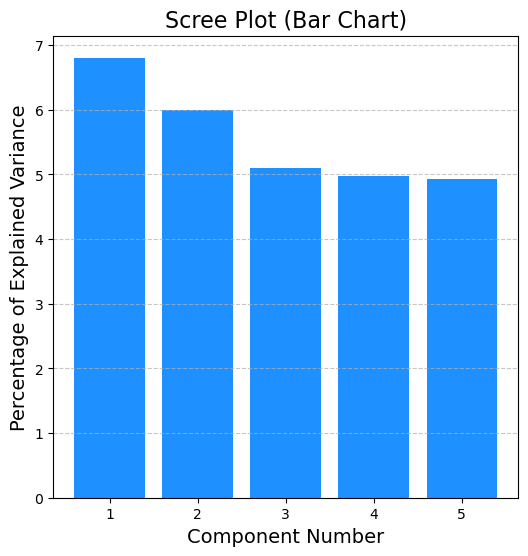

In [100]:
##plot scree plot
explained_variance_percent=famd.percentage_of_variance_
print(explained_variance_percent)

plt.figure(figsize=(6,6))
plt.bar(range(1, len(explained_variance_percent)+1), explained_variance_percent, color='#1E90FF')
plt.title('Scree Plot (Bar Chart)', fontsize=16)
plt.xlabel('Component Number', fontsize=14)
plt.ylabel('Percentage of Explained Variance', fontsize=14)
plt.xticks(range(1, len(explained_variance_percent)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

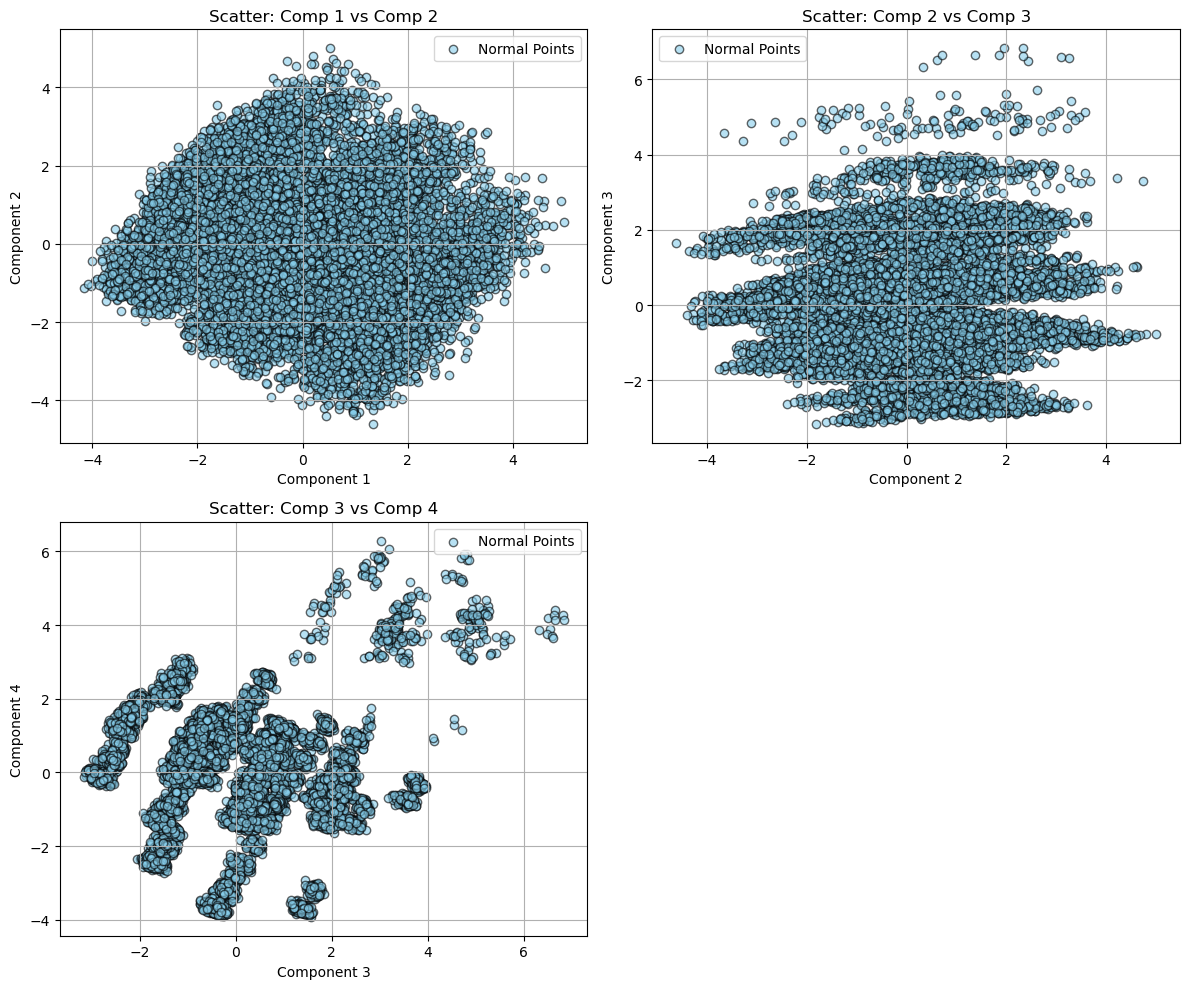

In [103]:
# Suppose 'outliers' contains the indices of detected outliers
normal_points = transform_data.drop(index=outliers)
outlier_points = transform_data.iloc[outliers]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easy indexing

# Loop through component pairs
for comp in range(transform_data.shape[1] - 2):  
    ax = axes[comp]  # Pick the subplot
    
    # Plot normal points
    ax.scatter(normal_points.iloc[:, comp], normal_points.iloc[:, comp+1], 
               color='skyblue', label='Normal Points', alpha=0.6, edgecolor='k')
    
    
    ax.set_xlabel(f'Component {comp+1}')
    ax.set_ylabel(f'Component {comp+2}')
    ax.set_title(f'Scatter: Comp {comp+1} vs Comp {comp+2}')
    ax.grid(True)
    ax.legend()

# If there are extra empty subplots (because you have fewer pairs), hide them
for i in range(comp+1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Apply K-mens Clustering

In [ ]:
##Fine the optimal K value(Number of clusters) using Lbow method
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array to easily index

# Loop over component pairs
for comp in range(transform_data.shape[1] - 2):
    wcss_error = []  # reset WCSS for each component pair
    data = transform_data.iloc[:, [comp, comp+1]]

    # Loop over the k values (clusters)
    for K in k_values:
        model = KMeans(n_clusters=K, random_state=42)
        model.fit(data)
        wcss_error.append(model.inertia_)

    # Plot WCSS error for this component pair in the corresponding subplot
    ax = axes[comp]  # Select the subplot
    ax.plot(k_values, wcss_error, marker='o')
    ax.set_xlabel("Number of Clusters (K)")
    ax.set_ylabel("WCSS (Inertia)")
    ax.set_title(f"Elbow Method: Comp {comp+1} vs Comp {comp+2}")
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
##Therefore optimal K values is K=3 and perform K-means clutering
optimal_model=KMeans(n_clusters=3,random_state=42)
# Step 3: Fit the KMeans model
optimal_model.fit(transform_data[['Comp_1','Comp_2']])

# Step 4: Get the cluster labels (assign each data point to a cluster)
labels = optimal_model.labels_
centroid=optimal_model.cluster_centers_

# Add the cluster labels to the original dataframe
transform_data['Cluster'] = labels

# Step 5: Visualize the clusters (only possible in 2D for now)
plt.scatter(transform_data['Comp_1'], transform_data['Comp_2'], c=transform_data['Cluster'], cmap='Accent')
# Plot the centroids
plt.scatter(centroid[:, 0], centroid[:, 1],c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-means Clustering')
plt.show()

Apply Silhouette score to check the validity of cluters

In [ ]:
s_score=silhouette_score(transform_data[['Comp_1','Comp_2']],labels,metric='euclidean')
s_score

In [ ]:
##save sampling data 
health_fitness_strat.to_csv("C:\\UOC pdf\\3rd Year\\MachineLearning-01\\final_project\\healthFitnessDataset.csv",index=False)

Finish EDA